<a href="https://colab.research.google.com/github/ShohamBirman/Projects/blob/main/Melanoma_Detection_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma Detection Model

#### [Melanoma Detection App](https://https://melanoma-detection-model-app.streamlit.app/)
#### [Presentation](https://https://www.canva.com/design/DAGCNHDKWnU/iHDnBF1e1AFGhs1DNFJ23g/edit?utm_content=DAGCNHDKWnU&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)


In [1]:
!pip install efficientnet_pytorch --q

  Preparing metadata (setup.py) ... done


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, auc, f1_score, classification_report
from efficientnet_pytorch import EfficientNet
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

#### The Dataset
The dataset, sourced from [Kaggle](https://https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset), contains 13,879 dermoscopic images, with 7,289 classified as benign and 6,590 as malignant. Each image has dimensions of 224x224 pixels. The dataset was pre-divided by Kaggle into a train set (85%=11,879) and a test set (15%=2,000).
Additionally, within the train set, an 80-20 split was further performed (train-set 80%=9503; validation-set 20%=2376) to evaluate the model's performance and its generalization ability during the training process.       

In [3]:
# Extract the dataset zip file
dataset_zip_path = "/content/archive.zip"
extracted_dir = "extracted_dataset"

In [4]:
with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_dir)

In [5]:
# Define paths to extracted directories
train_dir = os.path.join(extracted_dir, "train")
test_dir = os.path.join(extracted_dir, "test")

In [6]:
train_sizes = []
test_sizes = []
classes = os.listdir(train_dir)
for class_name in classes:
    train_size = len(os.listdir(os.path.join(train_dir, class_name)))
    test_size = len(os.listdir(os.path.join(test_dir, class_name)))
    train_sizes.append(train_size)
    test_sizes.append(test_size)

# Create a DataFrame and bar-plot for dataset sizes
data = {
    "Class": classes,
    "Train Size": train_sizes,
    "Test Size": test_sizes
}
df = pd.DataFrame(data)
df

,Class,Train Size,Test Size
0,Malignant,5590,1000
1,Benign,6289,1000


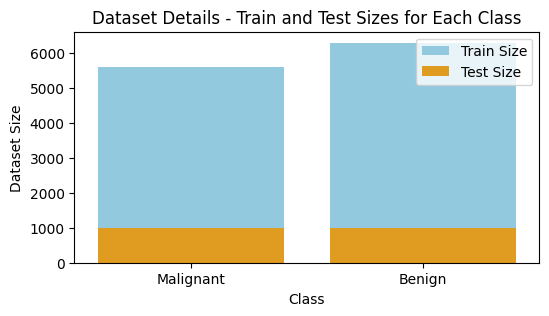

In [7]:
import seaborn as sns
plt.figure(figsize=(6, 3))
sns.barplot(x="Class", y="Train Size", data=df, color="skyblue", label="Train Size")
sns.barplot(x="Class", y="Test Size", data=df, color="orange", label="Test Size")
plt.title("Dataset Details - Train and Test Sizes for Each Class")
plt.xlabel("Class")
plt.ylabel("Dataset Size")
plt.legend()
plt.show()

In [8]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

#### Sample images from the dataset - benign and malignant

Sample Images from Train Dataset (Before Transformation):


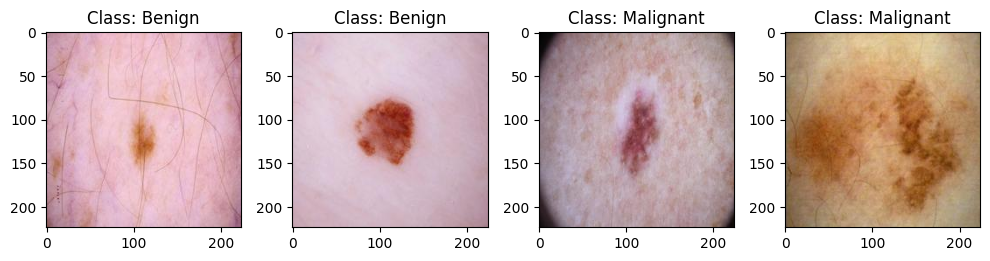

Sample Images from Test Dataset (Before Transformation):


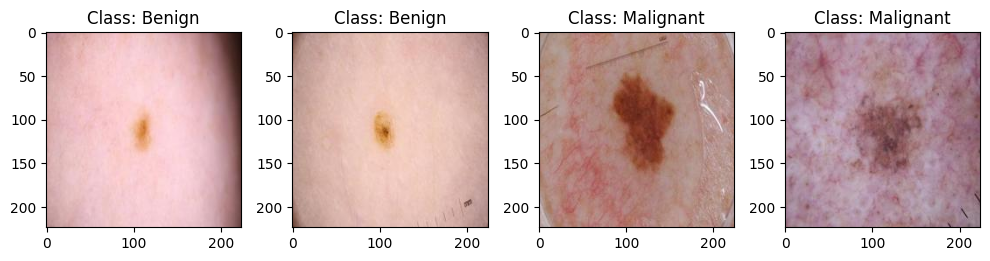

In [10]:
def plot_sample_images(dataset_dir, num_samples=4):
    classes = os.listdir(dataset_dir)
    fig, axs = plt.subplots(1, num_samples, figsize=(10, 5))

    # Select the desired classes
    selected_classes = ["Benign", "Malignant"]

    for i, class_name in enumerate(selected_classes):
        class_path = os.path.join(dataset_dir, class_name)
        image_names = os.listdir(class_path)
        random_image_names = random.sample(image_names, 2)  # Select 2 random images per class

        for j, image_name in enumerate(random_image_names):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path).convert("RGB")
            axs[i * 2 + j].imshow(image)
            axs[i * 2 + j].set_title(f"Class: {class_name}")

    plt.tight_layout()
    plt.show()

print("Sample Images from Train Dataset (Before Transformation):")
plot_sample_images(train_dir)
print("Sample Images from Test Dataset (Before Transformation):")
plot_sample_images(test_dir)

#### Data Augmentation

In [11]:
# Define separate transforms for train, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.CenterCrop(size=(112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Loading Dataset

In [16]:
# Define dataset class to load images from extracted directory
class ZipDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        classes = os.listdir(self.root)
        for idx, class_name in enumerate(classes):
            class_path = os.path.join(self.root, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load datasets
train_dataset = ZipDataset(train_dir, transform=train_transform)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Load test dataset
test_dataset = ZipDataset(test_dir, transform=test_transform)

In [17]:
# Calculate dataset sizes
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# Count the number of samples for each class in each dataset
def count_class_samples(dataset):
    class_counts = {}
    for _, label in dataset:
        class_name = "Malignant" if label == 1 else "Benign"
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1
    return class_counts

# Count class samples in each dataset
train_class_counts = count_class_samples(train_dataset)
val_class_counts = count_class_samples(val_dataset)
test_class_counts = count_class_samples(test_dataset)

# Print dataset sizes
print("Dataset Sizes:")
print("Train size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)
print()

# Print class counts in each dataset
print("Class Counts:")
print("Train:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")
print("Validation:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")
print("Test:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Dataset Sizes:
Train size: 9503
Validation size: 2376
Test size: 2000

Class Counts:
Train:
Malignant: 5034
Benign: 4469
Validation:
Benign: 1121
Malignant: 1255
Test:
Benign: 1000
Malignant: 1000


#### Sample transformed images from each dataset (train, validation, test).

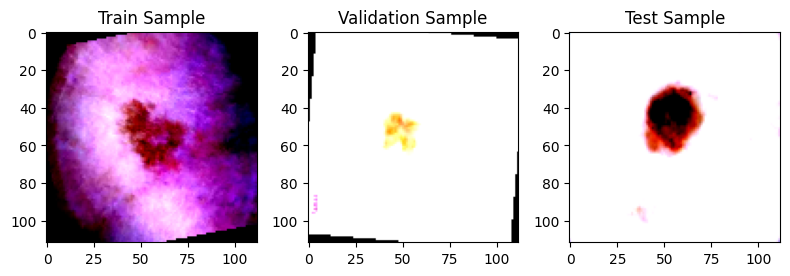

In [18]:
# Display a sample image from each dataset
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Plot sample images
def plot_sample_image(dataset, index, ax, title):
    image, label = dataset[index]
    image = image.permute(1, 2, 0).cpu().numpy()  # Move to CPU and permute for plotting
    ax.imshow(image)
    ax.set_title(title)

plot_sample_image(train_dataset, random.randint(0, len(train_dataset) - 1), axs[0], "Train Sample")
plot_sample_image(val_dataset, random.randint(0, len(val_dataset) - 1), axs[1], "Validation Sample")
plot_sample_image(test_dataset, random.randint(0, len(test_dataset) - 1), axs[2], "Test Sample")

plt.tight_layout()
plt.show()

#### Defining Model

In [19]:
# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [20]:
class MelanomaClassifier(nn.Module):
    def __init__(self):
        super(MelanomaClassifier, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Sequential(
            nn.Dropout(p=0.5),  # Add dropout layer
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, optimizer
model = MelanomaClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 46.0MB/s]

Loaded pretrained weights for efficientnet-b0


#### Training loop

In [21]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 60
early_stop_accuracy = 0.96
early_stop_patience = 10  # Number of epochs to wait for loss improvement
min_delta = 1e-5  # Minimum change in loss to be considered as improvement
best_val_loss = float('inf')
patience_counter = 0
best_accuracy = 0.0
best_model_state = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    epoch_train_accuracy = correct_train / total_train
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    epoch_val_accuracy = correct_val / total_val
    val_accuracies.append(epoch_val_accuracy)

    # Print the loss and accuracy for each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
    print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    # Learning rate scheduler
    scheduler.step(epoch_val_loss)

    # Early stopping based on accuracy
    if epoch_val_accuracy >= early_stop_accuracy:
        print(f"Early stopping at epoch {epoch + 1} due to high accuracy ({epoch_val_accuracy:.4f})")
        break

    # Early stopping based on loss stability (convergence)
    if epoch_val_loss < best_val_loss - min_delta:
        best_val_loss = epoch_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch + 1} due to loss stability")
        break

    # Save the best model state
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model_state = model.state_dict()

Epoch [1/60]
Train Loss: 0.3286, Train Accuracy: 0.8592
Validation Loss: 0.3730, Validation Accuracy: 0.8796
Epoch [2/60]
Train Loss: 0.2786, Train Accuracy: 0.8796
Validation Loss: 0.2782, Validation Accuracy: 0.8956
Epoch [3/60]
Train Loss: 0.2602, Train Accuracy: 0.8886
Validation Loss: 0.2757, Validation Accuracy: 0.9045
Epoch [4/60]
Train Loss: 0.2487, Train Accuracy: 0.8949
Validation Loss: 0.2776, Validation Accuracy: 0.8859
Epoch [5/60]
Train Loss: 0.2223, Train Accuracy: 0.9089
Validation Loss: 0.2772, Validation Accuracy: 0.8902
Epoch [6/60]
Train Loss: 0.2149, Train Accuracy: 0.9104
Validation Loss: 0.2723, Validation Accuracy: 0.8960
Epoch [7/60]
Train Loss: 0.2061, Train Accuracy: 0.9169
Validation Loss: 0.2764, Validation Accuracy: 0.8948
Epoch [8/60]
Train Loss: 0.1948, Train Accuracy: 0.9188
Validation Loss: 0.2429, Validation Accuracy: 0.9154
Epoch [9/60]
Train Loss: 0.1860, Train Accuracy: 0.9223
Validation Loss: 0.2826, Validation Accuracy: 0.8838
Epoch [10/60]
Train

#### Evaluation on the test set

In [22]:
# Load the best model state
model.load_state_dict(best_model_state)

# Evaluation on the test set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate recall, accuracy, F1-score, and classification report
recall_melanoma = recall_score(y_true, y_pred, pos_label=1)
recall_benign = recall_score(y_true, y_pred, pos_label=0)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=['Benign', 'Melanoma'])

print(f"Recall - Melanoma: {recall_melanoma:.4f}, Benign: {recall_benign:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(class_report)

Recall - Melanoma: 0.9500, Benign: 0.9450
Test Accuracy: 0.9475
F1 Score: 0.9476
Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.94      0.95      1000
    Melanoma       0.95      0.95      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



#### Training and Validation losses and accuracy per epoch

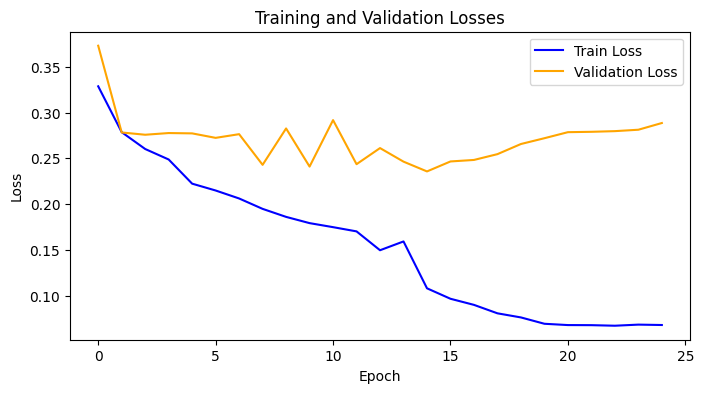

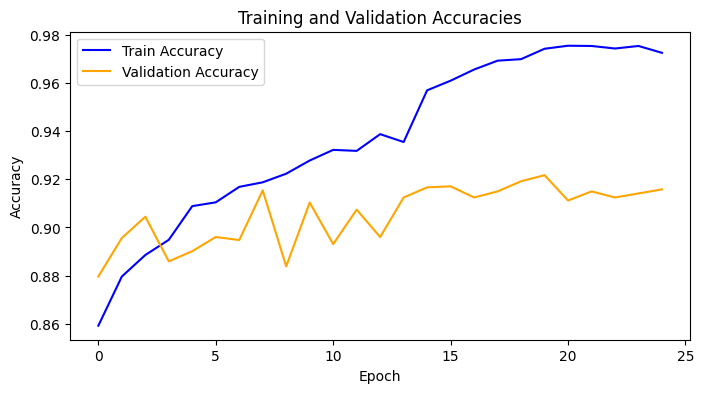

In [25]:
# Plot training and validation losses
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(8, 4))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

#### ROC CURVE

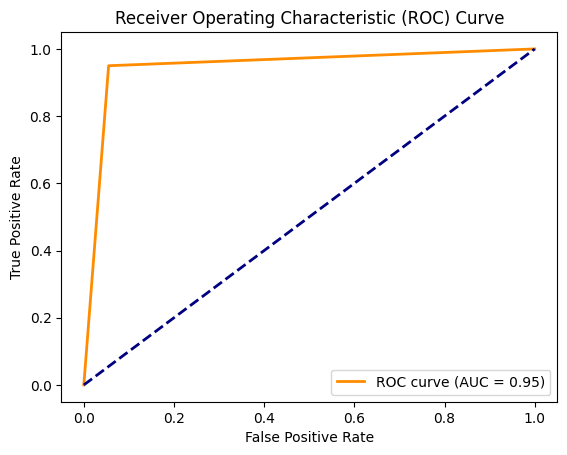

In [26]:
fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Confusion Metrix

In [27]:
import itertools

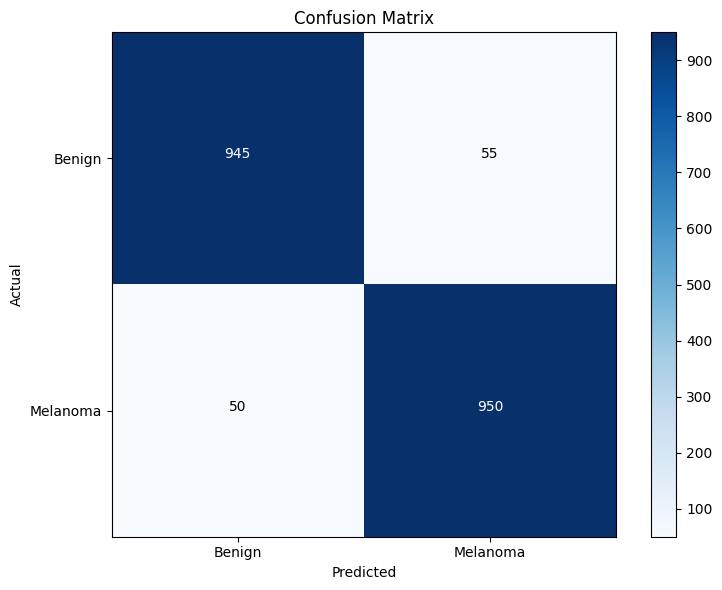

In [28]:
# Confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(2), ['Benign', 'Melanoma'])
plt.yticks(np.arange(2), ['Benign', 'Melanoma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

#### Save the model for external deployment

In [ ]:
# # Save the entire model
# model_path = 'melanoma_classifier_model_EfficientNet.pth'
# torch.save(model, model_path)

In [29]:
# Save the model weights
model_path = 'melanoma_classifier_weights_EfficientNet.pth'
torch.save(model.state_dict(), model_path)